<a href="https://colab.research.google.com/github/brushing-git/Hospital-Readmissions/blob/main/linear_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
from scipy.special import softmax
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount("/content/drive", force_remount=True)
location = 'drive/Shareddrives/273A/balanced_datasets'
X = pd.read_csv(os.path.join(location, 'X_train.csv'))
Y = pd.read_csv(os.path.join(location, 'Y_train.csv'))
X_int = pd.read_csv(os.path.join(location, 'X_train_integer.csv'))
Y_int = pd.read_csv(os.path.join(location, 'Y_train_integer.csv'))

Mounted at /content/drive


In [ ]:
# Combine Y with X
X['readmitted'] = Y['readmitted']
X_int['readmitted'] = Y_int['readmitted']

In [ ]:
class diabetesDataSet(Dataset):
    def __init__(self, data, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]  # get the sample
        sample = sample.to_numpy()  # convert to numpy
        features = sample[:len(sample)-1] # get the features, dropping the first item and the target
        target = sample[len(sample)-1] # set the target

        if self.transform:
            sample = self.transform(features)
        if self.target_transform:
            target = self.target_transform(target)

        return features, target

In [ ]:
class linearClassifier(torch.nn.Module):
    def __init__(self, dim, tar):
        super(linearClassifier, self).__init__()
        self.layer1 = torch.nn.Linear(dim, tar)
        self.activation = torch.nn.Sigmoid()

    def forward(self, x):
        y1 = self.layer1(x)
        return y1

def train_step(x, t, classifier, opt_fn, loss_fn):
  y = classifier(x.float())
  loss = loss_fn(y, t.long())
  loss.backward()
  opt_fn.step()
  opt_fn.zero_grad()
  return loss

In [ ]:
dataset1 = diabetesDataSet(X_int, transform=torch.from_numpy, target_transform=None)

train_size = round(0.8 * len(X_int))
va_size = round(0.2 * len(X_int))

tr_set, va_set = torch.utils.data.random_split(dataset1, [train_size, va_size])

In [ ]:
tr_loader = torch.utils.data.DataLoader(tr_set, batch_size=100, shuffle=True)
va_loader = torch.utils.data.DataLoader(va_set, batch_size=100, shuffle=True)

n_features = len(X_int.columns) - 1

model = linearClassifier(dim=n_features, tar=2)

loss = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

acc_hist_tr = []
acc_hist_va = []

for epoch in range(10):
  acc_batch = []
  model.train()
  for x,t in iter(tr_loader):
    loss_ = train_step(x, t, model, opt, loss)
    y = model(x.float())
    acc_batch.append(torch.mean((t == y.argmax(1)).float()))
  acc_hist_tr.append(torch.mean(torch.FloatTensor(acc_batch)))
  print(loss_)

  acc_batch = []
  model.eval()
  for x,t in iter(va_loader):
    y = model(x.float())
    acc_batch.append(torch.mean((t == y.argmax(1)).float()))
  acc_hist_va.append(torch.mean(torch.FloatTensor(acc_batch)))

tensor(0.5615, grad_fn=<NllLossBackward>)
tensor(0.6780, grad_fn=<NllLossBackward>)
tensor(0.6416, grad_fn=<NllLossBackward>)
tensor(0.7033, grad_fn=<NllLossBackward>)
tensor(0.6078, grad_fn=<NllLossBackward>)
tensor(0.7248, grad_fn=<NllLossBackward>)
tensor(0.6270, grad_fn=<NllLossBackward>)
tensor(0.6420, grad_fn=<NllLossBackward>)
tensor(0.6978, grad_fn=<NllLossBackward>)
tensor(0.6810, grad_fn=<NllLossBackward>)


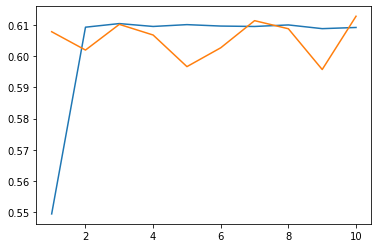

In [ ]:
x = [i for i in range(1, 11, 1)]
plt.plot(x, acc_hist_tr)
plt.plot(x, acc_hist_va)

In [ ]:
model.eval()
Ytr = []
YtrHat = []
Yva = []
YvaHat = []

for i in range(len(tr_set)):
  x, y = tr_set[i]
  yhat = model(torch.from_numpy(x).float())
  yhat = yhat.detach().numpy()
  yhat = softmax(yhat)
  Ytr.append(y)
  YtrHat.append(yhat)

for i in range(len(va_set)):
  x, y = va_set[i]
  yhat = model(torch.from_numpy(x).float())
  yhat = yhat.detach().numpy()
  yhat = softmax(yhat)
  Yva.append(y)
  YvaHat.append(yhat)

Ytr = np.asarray(Ytr)
YtrHat = np.asarray(YtrHat)
Yva = np.asarray(Yva)
YvaHat = np.asarray(YvaHat)

NameError: ignored

In [ ]:
def convert_to_1Hot(arr):
  arr = arr.astype(int)
  shape = (arr.size, arr.max()+1)
  one_hot = np.zeros(shape)
  rows = np.arange(arr.size)
  one_hot[rows, arr] = 1
  return one_hot

In [ ]:
print("AUC score on training is " + str(roc_auc_score(convert_to_1Hot(Ytr), YtrHat)))
print("AUC score on validation is " + str(roc_auc_score(convert_to_1Hot(Yva), YvaHat)))

AUC score on training is 0.6600980915701755
AUC score on validation is 0.6580066940903508


In [ ]:
dataset2 = diabetesDataSet(X, transform=torch.from_numpy, target_transform=None)

train_size = round(0.8 * len(X))
va_size = round(0.2 * len(X))

tr_set, va_set = torch.utils.data.random_split(dataset2, [train_size, va_size])

In [ ]:
tr_loader = torch.utils.data.DataLoader(tr_set, batch_size=100, shuffle=True)
va_loader = torch.utils.data.DataLoader(va_set, batch_size=100, shuffle=True)

n_features = len(X.columns) - 1

model = linearClassifier(dim=n_features, tar=2)

loss = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

acc_hist_tr = []
acc_hist_va = []

for epoch in range(10):
  acc_batch = []
  model.train()
  for x,t in iter(tr_loader):
    loss_ = train_step(x, t, model, opt, loss)
    y = model(x.float())
    acc_batch.append(torch.mean((t == y.argmax(1)).float()))
  acc_hist_tr.append(torch.mean(torch.FloatTensor(acc_batch)))
  print(loss_)

  acc_batch = []
  model.eval()
  for x,t in iter(va_loader):
    y = model(x.float())
    acc_batch.append(torch.mean((t == y.argmax(1)).float()))
  acc_hist_va.append(torch.mean(torch.FloatTensor(acc_batch)))

tensor(0.7318, grad_fn=<NllLossBackward>)
tensor(0.6251, grad_fn=<NllLossBackward>)
tensor(0.6616, grad_fn=<NllLossBackward>)
tensor(0.5829, grad_fn=<NllLossBackward>)
tensor(0.6799, grad_fn=<NllLossBackward>)
tensor(0.6511, grad_fn=<NllLossBackward>)
tensor(0.6397, grad_fn=<NllLossBackward>)
tensor(0.7147, grad_fn=<NllLossBackward>)
tensor(0.5970, grad_fn=<NllLossBackward>)
tensor(0.6959, grad_fn=<NllLossBackward>)


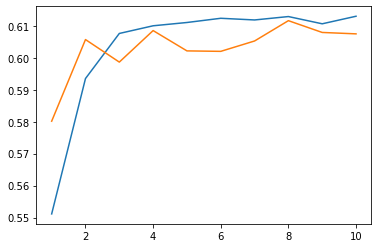

In [ ]:
x = [i for i in range(1, 11, 1)]
plt.plot(x, acc_hist_tr)
plt.plot(x, acc_hist_va)

In [ ]:
def compute_roc(model, tr_set, va_set):
  def convert_to_1Hot(arr):
    arr = arr.astype(int)
    shape = (arr.size, arr.max()+1)
    one_hot = np.zeros(shape)
    rows = np.arange(arr.size)
    one_hot[rows, arr] = 1
    return one_hot
  
  model.cpu()
  model.eval()
  Ytr = []
  YtrHat = []
  Yva = []
  YvaHat = []

  for i in range(len(tr_set)):
    x, y = tr_set[i]
    yhat = model(torch.from_numpy(x).float())
    yhat = yhat.detach().numpy()
    yhat = softmax(yhat)
    Ytr.append(y)
    YtrHat.append(yhat)

  for i in range(len(va_set)):
    x, y = va_set[i]
    yhat = model(torch.from_numpy(x).float())
    yhat = yhat.detach().numpy()
    yhat = softmax(yhat)
    Yva.append(y)
    YvaHat.append(yhat)

  Ytr = np.asarray(Ytr)
  YtrHat = np.asarray(YtrHat)
  Yva = np.asarray(Yva)
  YvaHat = np.asarray(YvaHat)
  auc_tr = roc_auc_score(convert_to_1Hot(Ytr), YtrHat)
  auc_va = roc_auc_score(convert_to_1Hot(Yva), YvaHat)
  return auc_tr, auc_va

In [ ]:
tr_auc, va_auc = compute_roc(model, tr_set, va_set)
print("AUC score on training is " + str(tr_auc))
print("AUC score on validation is " + str(va_auc))

AUC score on training is 0.6615970443289396
AUC score on validation is 0.6599583125358179


In [ ]:
X_te = pd.read_csv(os.path.join(location, 'X_test.csv'))
Y_te = pd.read_csv(os.path.join(location, 'Y_test.csv'))
X_te['readmitted'] = Y_te['readmitted']

te_set = diabetesDataSet(X_te, transform=torch.from_numpy, target_transform=None)
te_loader = torch.utils.data.DataLoader(te_set, batch_size=100, shuffle=True)

acc_batch = []
model.cpu()
model.eval()
for x,t in iter(te_loader):
  y = model(x.float())
  acc_batch.append(torch.mean((t == y.argmax(1)).float()))

acc = torch.mean(torch.FloatTensor(acc_batch))
te_auc, va_auc = compute_roc(model, te_set, va_set)
print('Accuracy ' + str(acc))
print('AUC ' + str(te_auc))

Accuracy tensor(0.6096)
AUC 0.654678673442977
